# Fault Detection on Time Series from Wind Turbine SCADA Data using LSTM Autoencoders with PyTorch in Python

## Mandatory Imports

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from torch.utils.data import ConcatDataset
import gc
import copy

## Dataset

### Dataset description

The ["CARE to Compare"](https://arxiv.org/abs/2404.10320) dataset is a real-world dataset designed for anomaly detection in wind turbine operations. It includes:
* Scope: Data from 36 wind turbines across three wind farms (A, B and C) (onshore and offshore) with detailed fault and anomaly information.
* Size: Contains 89 years' worth of Supervisory Control and Data Acquisition (SCADA) time-series data, split into 44 labeled time frames with anomalies and 51 normal behavior datasets.
* Features: The number of features varies by wind farm, ranging from 86 to 957. Data includes sensor measurements like power and wind speed, along with descriptive features like timestamps and turbine status.
* Resolution: Time-series data is recorded at 10-minute intervals.
* Labels: Anomalies are labeled with start and end timestamps, and additional turbine statuses (e.g., normal, fault, service mode) are provided.
* Quality Control: Data quality issues such as missing values and inconsistent status logs are addressed, and anonymization preserves confidentiality.
* Benchmarking: The dataset is paired with a proposed CARE-score (Coverage, Accuracy, Reliability, Earliness) to evaluate and compare anomaly detection models effectively.

This dataset is particularly valuable for advancing predictive maintenance techniques for wind turbines.
The dataset can be downloaded [here](https://zenodo.org/records/14006163).

**Note: for the context of this notebook, we will only use the data from Wind Turbine A.**

![Anomaly Detection Graph](../docs/img/care_to_compare_graph.png)

### Utility functions for loading data

Functions that will be used to load the information and sensor data for each windturbine

In [92]:
def find_all_wt(farm_path):
    """
    Find all wind turbine IDs in a wind farm directory
    """
    return [x for x in os.listdir(f"{farm_path}/datasets") if x.endswith(".csv")]

def load_wind_farm_data(farm_path, event_ids):
    """
    Load and combine multiple CSV files from a wind farm directory
    """
    dfs = []
    for event_id in event_ids:
        df = pd.read_csv(f"{farm_path}/datasets/{event_id}", sep=';')
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def load_event(farm_path, event_id):
    """
    Load and combine multiple CSV files from a wind farm directory
    """
    return pd.read_csv(f"{farm_path}/datasets/{event_id}", sep=';')

def load_event_info(farm_path):
    """
    Load event information CSV file
    """
    return pd.read_csv(f"{farm_path}/event_info.csv", sep=';')

def load_feature_description(farm_path):
    """
    Load feature description CSV file
    """
    return pd.read_csv(f"{farm_path}/feature_description.csv", sep=';')

### Load the data

Provide the dataset folder and load every event from every wind farm. Once again, for simplicity reasons, we will work on Wind Farm A only.

In [94]:
# Set the path to the dataset
import pandas as pd
dataset_folder = r"D:/Data/datasets/CARE_To_Compare"
# windfarms = ["Wind Farm A", "Wind Farm B", "Wind Farm C"]
windfarms = ["Wind Farm A"]

data = {}
for farm in windfarms:
    print(f"Processing {farm}")

    # Set the path to your wind farm data
    farm_path = os.path.join(dataset_folder, farm)

    # Load metadata files
    event_info = load_event_info(farm_path)
    feature_desc = load_feature_description(farm_path)

    # Load first few events as example
    event_ids = find_all_wt(farm_path)
    print(f"Found {len(event_ids)} events in {farm}")
    # event_ids = ['0.csv', '3.csv', '10.csv']  # Adjust based on your actual file names
    
    events = {}
    for event_id in event_ids:
        print(f"Processing event {event_id}")
        df = load_event(farm_path, event_id)
        events[event_id] = df
    
    data[farm] = {
        "event_info": event_info,
        "feature_desc": feature_desc,
        "events": events
    }


Processing Wind Farm A
Found 22 events in Wind Farm A
Processing event 0.csv
Processing event 10.csv
Processing event 13.csv
Processing event 14.csv
Processing event 17.csv
Processing event 22.csv
Processing event 24.csv
Processing event 25.csv
Processing event 26.csv
Processing event 3.csv
Processing event 38.csv
Processing event 40.csv
Processing event 42.csv
Processing event 45.csv
Processing event 51.csv
Processing event 68.csv
Processing event 69.csv
Processing event 71.csv
Processing event 72.csv
Processing event 73.csv
Processing event 84.csv
Processing event 92.csv


## Preprocessing

## Dataset handler

Create a dataset handler that will load the data and scale them between -1 and 1

In [95]:
# Create normalized Dataset class
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class WindTurbineDataset(Dataset):
    def __init__(self, data, sequence_length=144):
        self.sequence_length = sequence_length
        
        # Separate features and normalize
        feature_cols = [col for col in data.columns if col != 'train_test']
        features = data[feature_cols].values
        
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(features)
        
    def __len__(self):
        return len(self.features) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        sequence = self.features[idx:(idx + self.sequence_length)]
        return torch.FloatTensor(sequence)

We will create a function to differenciate the time series data to remove any trend

In [96]:
def create_differenced_series(df, selected_features):
    '''
    Create function to preprocess data with selected features
    '''
    # Drop administrative columns
    df_processed = df.drop(['time_stamp', 'asset_id', 'id'], axis=1)
    
    # Convert train_test to numeric
    df_processed['train_test'] = (df_processed['train_test'] == 'prediction').astype(int)
    
    # Calculate differences for each selected feature
    df_diff = pd.DataFrame()
    for feature in selected_features:
        if feature != 'status_type_id':  # Don't difference categorical variables
            df_diff[f'{feature}_diff'] = df_processed[feature].diff()
        else:
            df_diff[feature] = df_processed[feature]
    
    # Drop first row which will be NaN due to differencing
    df_diff = df_diff.dropna()
    
    # Add train_test column back
    df_diff['train_test'] = df_processed['train_test'][1:]  # Shift by 1 due to differencing
    
    return df_processed, df_diff

In [97]:
def process_all_events(data, selected_features):
    """
    Process all events in the wind farm data
    Returns combined training and testing datasets
    """
    all_train_datasets = []
    all_test_datasets = []
    
    for event_id, df in data['Wind Farm A']['events'].items():
        print(f"Processing event {event_id}")
        
        # Process the event data
        df_processed, df_differenced = create_differenced_series(df, selected_features)
        
        # Split into train and test
        train_data = df_differenced[df_differenced['train_test'] == 0]
        test_data = df_differenced[df_differenced['train_test'] == 1]
        
        if len(train_data) > 0:
            train_dataset = WindTurbineDataset(train_data)
            all_train_datasets.append(train_dataset)
            
        if len(test_data) > 0:
            test_dataset = WindTurbineDataset(test_data)
            all_test_datasets.append(test_dataset)
        
        # Clean up to manage memory
        del df_processed, df_differenced, train_data, test_data
        gc.collect()
    
    # Combine all datasets
    combined_train_dataset = ConcatDataset(all_train_datasets)
    combined_test_dataset = ConcatDataset(all_test_datasets)
    
    return combined_train_dataset, combined_test_dataset

## Model training

### LSTM model

In [98]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMAutoencoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Encoder with larger hidden size and dropout
        self.lstm_encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Decoder
        self.lstm_decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Final linear layer to match input size
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # Encoder
        encoded_output, (hidden, cell) = self.lstm_encoder(x)
        
        # Decoder
        decoded_output, _ = self.lstm_decoder(encoded_output)
        
        # Final reconstruction
        reconstruction = self.linear(decoded_output)
        
        return reconstruction

In [99]:
# Your existing selected features
selected_features = [
    'sensor_41_avg',    # hydraulic oil temp
    'sensor_11_avg',    # gearbox temp
    'sensor_13_avg',    # generator bearing temp
    'wind_speed_3_avg', # wind speed
    'power_29_avg',     # power measurement
    'status_type_id'    # operational state
]

# Get combined datasets
print("Combining datasets from all events...")
combined_train_dataset, combined_test_dataset = process_all_events(data, selected_features)

print(f"Total training sequences: {len(combined_train_dataset)}")
print(f"Total testing sequences: {len(combined_test_dataset)}")

# Create dataloaders
batch_size = 32
train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
input_size = len(selected_features)  # Number of features after processing
model = LSTMAutoencoder(input_size=input_size)

Combining datasets from all events...
Processing event 0.csv
Processing event 10.csv
Processing event 13.csv
Processing event 14.csv
Processing event 17.csv
Processing event 22.csv
Processing event 24.csv
Processing event 25.csv
Processing event 26.csv
Processing event 3.csv
Processing event 38.csv
Processing event 40.csv
Processing event 42.csv
Processing event 45.csv
Processing event 51.csv
Processing event 68.csv
Processing event 69.csv
Processing event 71.csv
Processing event 72.csv
Processing event 73.csv
Processing event 84.csv
Processing event 92.csv
Total training sequences: 1142986
Total testing sequences: 47447


### Training loop

In [100]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=200, learning_rate=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Use Adam with different learning rate and weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Loss function
    criterion = nn.MSELoss()
    
    train_losses = []
    best_loss = float('inf')
    patience_counter = 0
    patience = 10  # Early stopping patience
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            output = model(batch)
            loss = criterion(output, batch)
            
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_loss)
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Log scale to better see improvements
    plt.grid(True)
    plt.show()
    
    model.load_state_dict(best_model_wts)
    return model, train_losses

Training model...
Epoch [5/1000], Loss: 0.0132, LR: 0.001000
Epoch [10/1000], Loss: 0.0116, LR: 0.001000
Epoch [15/1000], Loss: 0.0111, LR: 0.001000
Epoch [20/1000], Loss: 0.0109, LR: 0.001000
Epoch [25/1000], Loss: 0.0107, LR: 0.001000
Epoch [30/1000], Loss: 0.0107, LR: 0.001000
Epoch [35/1000], Loss: 0.0107, LR: 0.001000
Epoch [40/1000], Loss: 0.0107, LR: 0.001000
Epoch [45/1000], Loss: 0.0105, LR: 0.001000
Epoch [50/1000], Loss: 0.0105, LR: 0.001000
Epoch [55/1000], Loss: 0.0098, LR: 0.000500
Epoch [60/1000], Loss: 0.0093, LR: 0.000250
Epoch [65/1000], Loss: 0.0093, LR: 0.000125
Epoch [70/1000], Loss: 0.0090, LR: 0.000125
Epoch [75/1000], Loss: 0.0090, LR: 0.000125
Epoch [80/1000], Loss: 0.0087, LR: 0.000063
Epoch [85/1000], Loss: 0.0087, LR: 0.000063
Epoch [90/1000], Loss: 0.0086, LR: 0.000031
Epoch [95/1000], Loss: 0.0086, LR: 0.000031
Epoch [100/1000], Loss: 0.0086, LR: 0.000016
Epoch [105/1000], Loss: 0.0086, LR: 0.000016
Epoch [110/1000], Loss: 0.0086, LR: 0.000016
Epoch [115/1

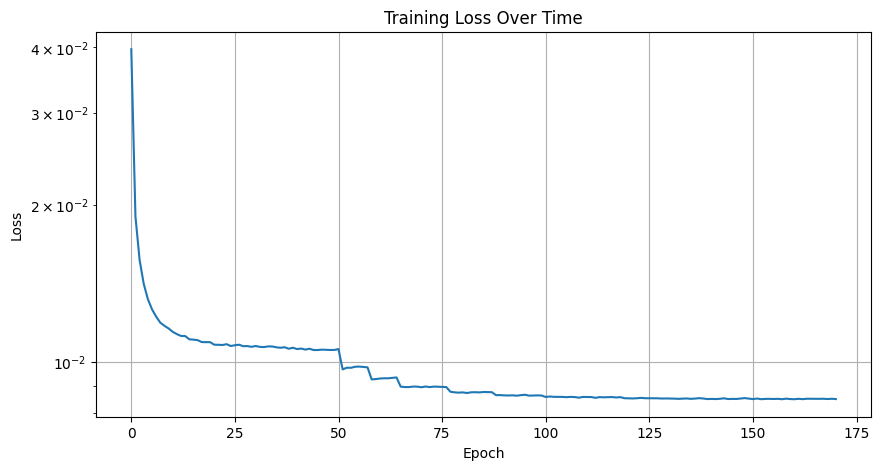

In [ ]:
# Train the model
print("Training model...")
model, losses = train_and_evaluate(model, train_loader, test_loader, num_epochs=1000)

# Save the model
MODEL_PATH = 'wt_anomaly_prediction_model_all_events.pth'
torch.save(model, MODEL_PATH)

The Training loss tends toward a plateau value of 0.085 at around epoch 120 and is stopped around epoch 170.

The shape of the loss curve corresponds to a good training loss curve. This is encouraging!

If you want to skip the training loop, you just need to uncomment the code block below to load the pretrained model.

In [ ]:
# model = torch.load('wt_anomaly_prediction_model_all_events.pth')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

C:\Users\pleno\AppData\Local\Temp\ipykernel_39960\233503228.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('wt_anomaly_prediction_model_all_events2.p

## Reconstruction errors

Now that the model is training, we can compute the differences between the model predictions and the real values.

This corresponds to the reconstruction errors.

In [102]:
# Calculate reconstruction errors
def calculate_reconstruction_errors(model, dataloader, device):
    model.eval()
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            
            # Calculate error for each timestep in the sequence
            error = torch.mean((output - batch) ** 2, dim=2)  # Mean across features
            reconstruction_errors.extend(error.cpu().numpy())
    
    return np.array(reconstruction_errors)

# Calculate errors for both training and test sets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_errors = calculate_reconstruction_errors(model, train_loader, device)
test_errors = calculate_reconstruction_errors(model, test_loader, device)

We can then set a manual treshold value that will be later used to detect anomalies.

In [104]:
# Set threshold based on training errors (e.g., 95th percentile)
threshold = np.percentile(train_errors, 98)

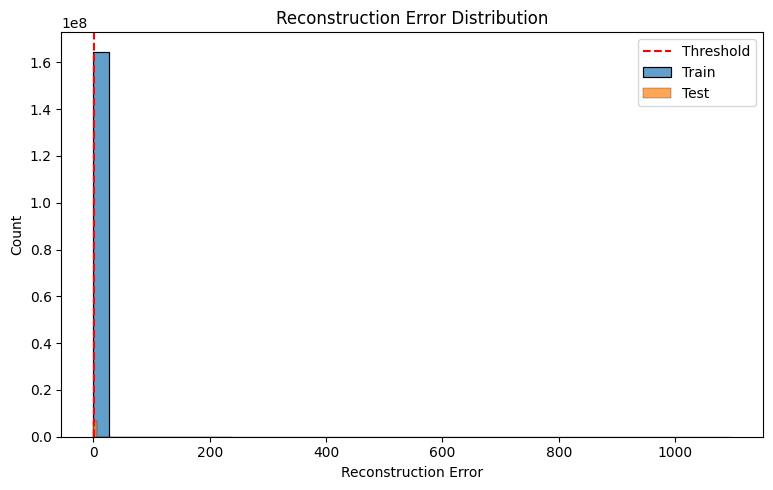

In [107]:
# Plot Error Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
sns.histplot(train_errors.flatten(), bins=40, label='Train', alpha=0.7)
sns.histplot(test_errors.flatten(), bins=40, label='Test', alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

Most errors are concentrated near zero, which is good.
The distribution is similar for both train and test sets, indicating consistent model behavior.

## Anomaly detection

Now that we are able to compute de reconstruction errors, we can work on the anomaly detections.

First, let's plot the reconstuction values versus the real values for a few sensors.

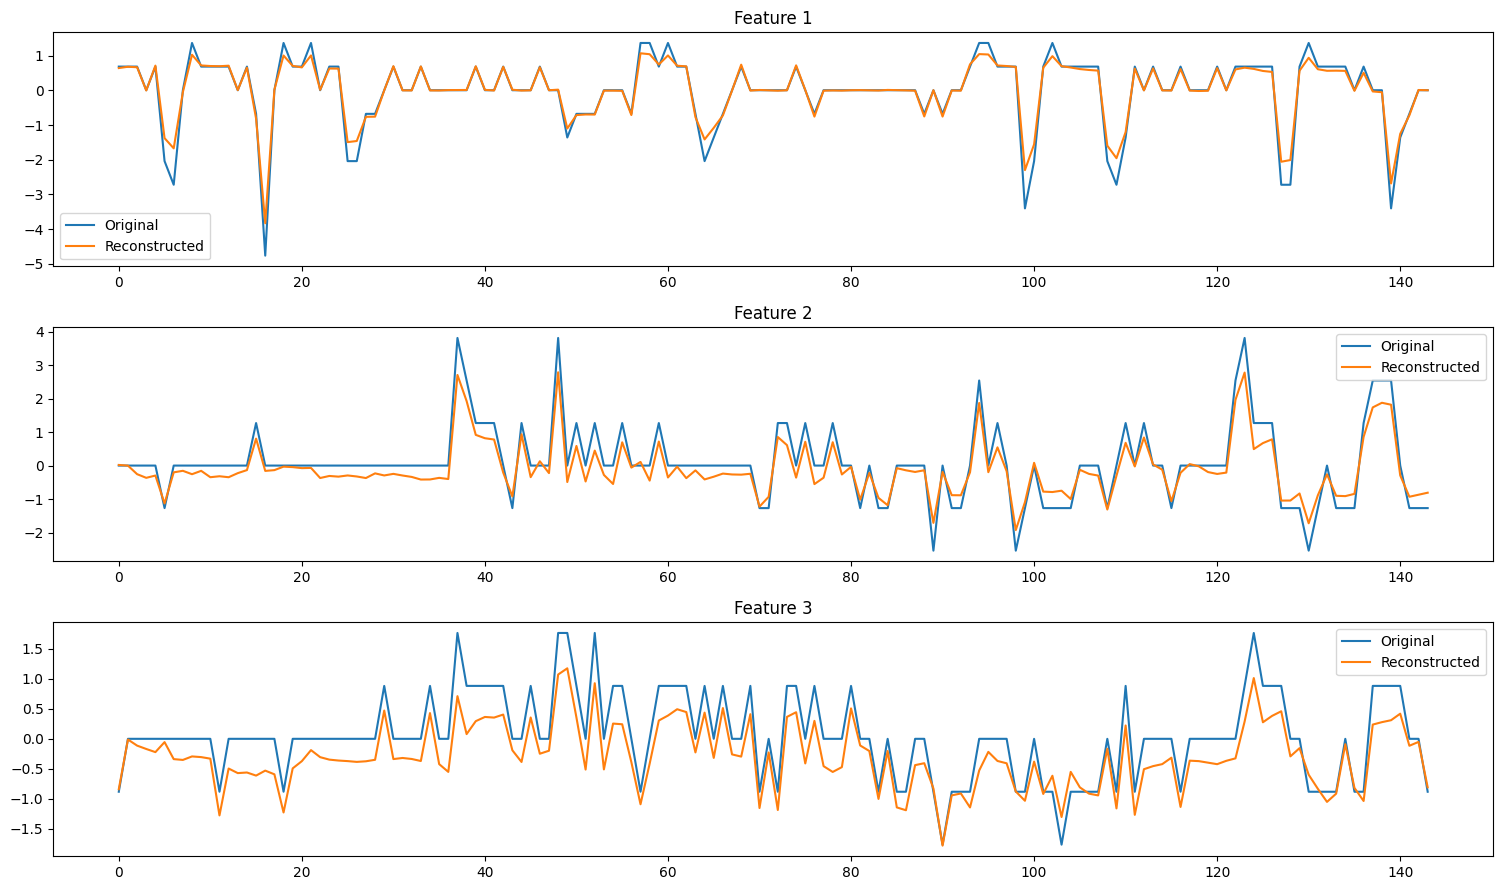

In [108]:
# Visualize original vs reconstructed sequences for a sample
def plot_reconstructions(model, dataloader, n_features=3):
    model.eval()
    # Get one batch
    batch = next(iter(dataloader))
    with torch.no_grad():
        reconstruction = model(batch.to(device)).cpu()
    
    # Plot first sequence in the batch
    plt.figure(figsize=(15, 3*n_features))
    for i in range(n_features):
        plt.subplot(n_features, 1, i+1)
        plt.plot(batch[0, :, i].numpy(), label='Original')
        plt.plot(reconstruction[0, :, i].numpy(), label='Reconstructed')
        plt.title(f'Feature {i+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_reconstructions(model, test_loader)

Now if we want to detect anomalies, we simply have to use the threshold defined earlier to detect them. Anything over the threshold will be labelled as an anomaly.

In [109]:
# Detect anomalies and evaluate performance
def detect_anomalies(errors, threshold):
    return errors > threshold

# Calculate anomaly scores
train_anomalies = detect_anomalies(train_errors, threshold)
test_anomalies = detect_anomalies(test_errors, threshold)

# Calculate percentage of anomalies
train_anomaly_percentage = train_anomalies.mean() * 100
test_anomaly_percentage = test_anomalies.mean() * 100

print(f"Percentage of anomalies in training set: {train_anomaly_percentage:.2f}%")
print(f"Percentage of anomalies in test set: {test_anomaly_percentage:.2f}%")

Percentage of anomalies in training set: 2.00%
Percentage of anomalies in test set: 2.01%


We can now compute anomaly scores using a time window of 18 steps, corresponding to 3 hours (1 step = 10 min in this dataset)

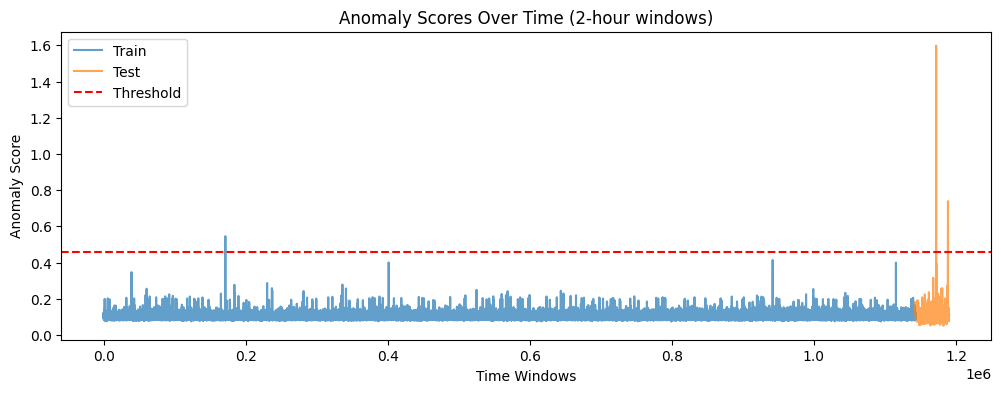

In [111]:
# Block 3: Calculate anomaly scores over time windows
def calculate_anomaly_scores(errors, window_size=18):  # 12 timesteps = 2 hours
    scores = []
    for i in range(len(errors) - window_size + 1):
        window = errors[i:i+window_size]
        scores.append(np.mean(window))
    return np.array(scores)

# Calculate windowed anomaly scores
train_scores = calculate_anomaly_scores(train_errors.mean(axis=1))
test_scores = calculate_anomaly_scores(test_errors.mean(axis=1))

# Plot anomaly scores
plt.figure(figsize=(12, 4))
plt.plot(train_scores, label='Train', alpha=0.7)
plt.plot(np.arange(len(train_scores), len(train_scores) + len(test_scores)), 
         test_scores, label='Test', alpha=0.7)
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Scores Over Time (2-hour windows)')
plt.xlabel('Time Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

Using a single threshold may limit us in defining a granularity in terms of anomaly detection.

We can now defined multiple thresholds: Warning, Alert and Critical. Each of them will give us a warning level of detection and may help the end-user have a better grasp on the situation.

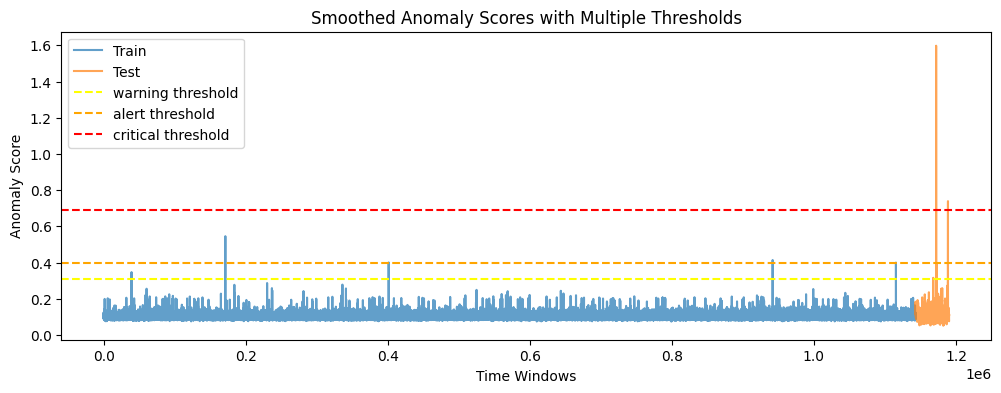

In [ ]:
# Calculate multiple thresholds for different severity levels
thresholds = {
    'warning': np.percentile(train_errors, 96),
    'alert': np.percentile(train_errors, 97.5),
    'critical': np.percentile(train_errors, 99)
}
plt.figure(figsize=(12, 4))
plt.plot(train_scores, label='Train', alpha=0.7)
plt.plot(np.arange(len(train_scores), 
         len(train_scores) + len(test_scores)),
         test_scores, label='Test', alpha=0.7)

plt.axhline(thresholds["warning"], linestyle='--', label='warning threshold', color="yellow")
plt.axhline(thresholds["alert"], linestyle='--', label='alert threshold', color="orange")
plt.axhline(thresholds["critical"], linestyle='--', label='critical threshold', color="red")

plt.title('Anomaly Scores with Multiple Thresholds')
plt.xlabel('Time Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

# Early warning

In [116]:
# Block 1: Implement trend analysis functions
import numpy as np
from scipy import stats

def calculate_trend_indicators(scores, window_size=144):  # 24 hours
    """Calculate various trend indicators for early warning"""
    trends = []
    
    for i in range(len(scores) - window_size + 1):
        window = scores[i:i + window_size]
        
        # 1. Linear trend (slope)
        slope, _, _, _, _ = stats.linregress(range(len(window)), window)
        
        # 2. Volatility (standard deviation)
        volatility = np.std(window)
        
        # 3. Rate of change (percentage change over window)
        roc = (window[-1] - window[0]) / window[0] if window[0] != 0 else 0
        
        # 4. Acceleration (change in slope)
        half = window_size // 2
        slope1, _, _, _, _ = stats.linregress(range(half), window[:half])
        slope2, _, _, _, _ = stats.linregress(range(half), window[half:])
        acceleration = slope2 - slope1
        
        trends.append({
            'slope': slope,
            'volatility': volatility,
            'rate_of_change': roc,
            'acceleration': acceleration
        })
    
    return pd.DataFrame(trends)

In [117]:
# Block 2: Define warning levels based on trend patterns
def detect_early_warnings(trends_df, thresholds):
    """Detect different levels of warnings based on trend patterns"""
    warnings = pd.DataFrame(index=trends_df.index)
    
    warnings['warning_level'] = 0  # Normal
    
    # Level 1: Minor concerning trends
    warnings.loc[(trends_df['slope'] > thresholds['slope_minor']) |
                 (trends_df['volatility'] > thresholds['volatility_minor']), 'warning_level'] = 1
    
    # Level 2: Moderate risk
    warnings.loc[(trends_df['slope'] > thresholds['slope_moderate']) |
                 (trends_df['acceleration'] > thresholds['acceleration_moderate']) |
                 (trends_df['rate_of_change'] > thresholds['roc_moderate']), 'warning_level'] = 2
    
    # Level 3: High risk - multiple indicators
    warnings.loc[((trends_df['slope'] > thresholds['slope_high']) &
                 (trends_df['volatility'] > thresholds['volatility_high'])) |
                (trends_df['acceleration'] > thresholds['acceleration_high']), 'warning_level'] = 3
    
    return warnings

# Calculate baseline thresholds from training data
def calculate_trend_thresholds(train_trends):
    """Calculate thresholds for different warning levels"""
    return {
        'slope_minor': np.percentile(train_trends['slope'], 75),
        'slope_moderate': np.percentile(train_trends['slope'], 90),
        'slope_high': np.percentile(train_trends['slope'], 95),
        'volatility_minor': np.percentile(train_trends['volatility'], 75),
        'volatility_high': np.percentile(train_trends['volatility'], 95),
        'acceleration_moderate': np.percentile(train_trends['acceleration'], 90),
        'acceleration_high': np.percentile(train_trends['acceleration'], 95),
        'roc_moderate': np.percentile(train_trends['rate_of_change'], 90)
    }

In [ ]:
# Block 3: Visualize the early warnings
def plot_early_warnings(scores, warnings, window_size=144):
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Anomaly Scores with Warning Levels
    plt.subplot(2, 1, 1)
    plt.plot(scores, label='Anomaly Score', color='blue', alpha=0.6)
    
    # Color-code warning levels
    colors = ['green', 'yellow', 'orange', 'red']
    warning_levels = warnings['warning_level'].values
    
    for level in range(4):
        mask = warning_levels == level
        if np.any(mask):
            plt.scatter(np.where(mask)[0], scores[mask], 
                       color=colors[level], alpha=0.5,
                       label=f'Warning Level {level}')
    
    plt.title('Anomaly Scores with Warning Levels')
    plt.legend()
    
    # Plot 2: Trend Indicators
    plt.subplot(2, 1, 2)
    trends_df = calculate_trend_indicators(scores, window_size)
    
    plt.plot(trends_df['slope'], label='Slope', alpha=0.7)
    plt.plot(trends_df['acceleration'], label='Acceleration', alpha=0.7)
    plt.plot(trends_df['volatility'], label='Volatility', alpha=0.7)
    
    plt.title('Trend Indicators')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Apply the early warning system
train_scores = calculate_anomaly_scores(train_errors.mean(axis=1))
test_scores = calculate_anomaly_scores(test_errors.mean(axis=1))

# Calculate trends for training data
train_trends = calculate_trend_indicators(train_scores)
trend_thresholds = calculate_trend_thresholds(train_trends)

# Calculate trends and warnings for test data
test_trends = calculate_trend_indicators(test_scores)
test_warnings = detect_early_warnings(test_trends, trend_thresholds)

# Visualize results
plot_early_warnings(test_scores, test_warnings)

In [ ]:
# Block 4: Calculate warning lead time
def analyze_warning_effectiveness(warnings, actual_anomalies, window_size=144):
    """Analyze how early warnings detect anomalies"""
    warning_lead_times = []
    
    # Find actual anomaly events (using the original threshold)
    anomaly_events = np.where(actual_anomalies)[0]
    
    for anomaly_idx in anomaly_events:
        # Look back from each anomaly to find first warning
        for i in range(max(0, anomaly_idx - window_size), anomaly_idx):
            if warnings.iloc[i]['warning_level'] > 0:
                lead_time = anomaly_idx - i
                warning_lead_times.append(lead_time)
                break
    
    return {
        'average_lead_time': np.mean(warning_lead_times) if warning_lead_times else 0,
        'min_lead_time': np.min(warning_lead_times) if warning_lead_times else 0,
        'max_lead_time': np.max(warning_lead_times) if warning_lead_times else 0,
        'warning_count': len(warning_lead_times),
        'detection_rate': len(warning_lead_times) / len(anomaly_events) if len(anomaly_events) > 0 else 0
    }

# Calculate effectiveness metrics
test_anomalies = test_errors.mean(axis=1) > threshold
effectiveness = analyze_warning_effectiveness(test_warnings, test_anomalies)
print("\nEarly Warning System Performance:")
for metric, value in effectiveness.items():
    print(f"{metric}: {value:.2f}")